In [38]:
import pandas as pd
import itertools
import collections
import numpy as np
from tqdm import tqdm
import gensim
import re
import json
import sklearn
import matplotlib.pyplot as plt

In [2]:
filename_issues = '/home/dafne/shared/FilterBubble/issue-positions/issues-queries.csv'
filename_fasttext = '/home/dafne/shared/FilterBubble/word-embeddings/fasttext-aem-amcat50.bin'

In [3]:
# Load issues
df_issues = pd.read_csv(filename_issues)

In [4]:
# Load model
model = gensim.models.fasttext.load_facebook_model(filename_fasttext)

# If model file contains the raw word vectors, use:
# model = gensim.models.KeyedVectors.load_word2vec_format(filename_fasttext)

In [5]:
issues_dict = df_issues.groupby('parentI')['queryIssue'].agg(list).to_dict()

## Expand queries with wild cards
Some query words contain asterices for pattern matching. We expand the query set to include all words from the embedding vocabulary that match the pattenrs

In [16]:
# Retrieve vocabulary of embedding model
vocab = model.wv.vocab.keys()
len(vocab)

1143658

In [25]:
issues_dict_expanded = collections.defaultdict(list)

for issue, query_list in issues_dict.items():
    print(issue)
    for query_term in query_list:
        if '*' in query_term:
            query_regex = re.compile(query_term.replace('*', '.*'))
            new_queries = [v for v in vocab if query_regex.fullmatch(v) ]
            issues_dict_expanded[issue].extend(new_queries)
        else:
            issues_dict_expanded[issue].append(query_term)

EuropeseUnie
Infrastructuur
OenW
begrotingssaldo
belastHeffing
bestVernieuw
bestrijdingCrim
coronabestrijding
coronaverspreiding
geZorg
infrastructuur
integratie
klimaatMilieu
normenWaarden
ondernemingsklimaat
ontwikHulp
ontwikkelingCrim
socZek
terreurbestrijding
vrijheidsrechten
werk
woning


In [7]:
filename_out = '/home/dafne/shared/FilterBubble/issue-positions/queries-asterix-expanded.json'
# with open(filename_out, 'w') as fout:
#     json.dump(issues_dict_expanded, fout, indent=0)
with open(filename_out) as file:
    issues_dict_expanded = json.load(file)

In [18]:
# Compare nr of original queries, nr of expanded query
pd.DataFrame.from_dict(
    [{'issue': issue, 'original': len(issues_dict[issue]), 'expanded': len(issues_dict_expanded[issue])} for issue in issues_dict],
orient='columns'
)

,issue,original,expanded
0,EuropeseUnie,24,33
1,Infrastructuur,69,5094
2,OenW,65,3797
3,begrotingssaldo,20,221
4,belastHeffing,53,545
5,bestVernieuw,13,98
6,bestrijdingCrim,45,636
7,coronabestrijding,65,623
8,coronaverspreiding,25,285
9,geZorg,61,3746


## Cross validation
For each topic, do a cross validation and calculate prec and rec plots

In [20]:
issue_list = [issue for issue in issues_dict_expanded.keys() if issue != 'infrastructuur']

In [21]:
def get_prec_recs(nearest_neighbors, test_words):
    """
    Calculates precision and recall for each top-n nearest neighbors
    """
    precisions = []
    recall = []
    nr_true_positives = 0
    for i, (word, score) in enumerate(nearest_neighbors):
        if word in test_words:
            nr_true_positives += 1
        p = nr_true_positives / (i+1)
        r = nr_true_positives / len(test_words)
        precisions.append(p)
        recall.append(r)
    prec_rec_df = pd.DataFrame({'precision': precisions, 'recall': recall})
    return prec_rec_df

In [41]:
def split_query_words(query_words, split_ratio=0.5):
    """
    Split the query words in a 'seed set' and a test/validation set
    """
    all_query_words = np.array(query_words)
    np.random.shuffle(all_query_words)

    nr_seeds = int(np.ceil(split_ratio * len(all_query_words)))
    seed_words = all_query_words[:nr_seeds]
    test_words = all_query_words[nr_seeds:]
    return seed_words, test_words

/home/dafne/anaconda3/envs/nlp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


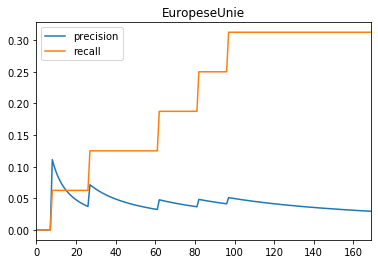

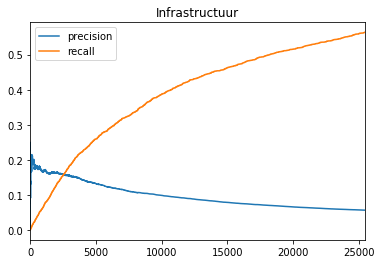

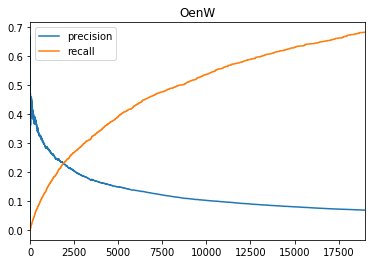

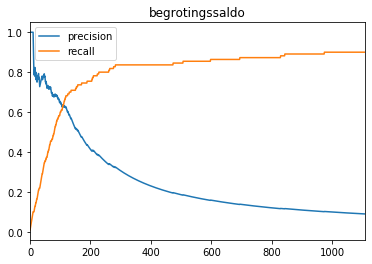

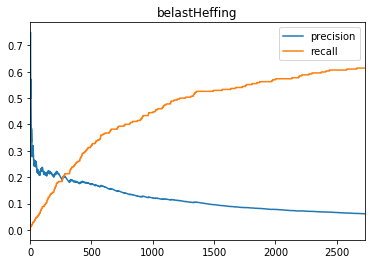

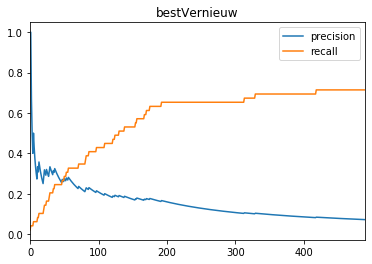

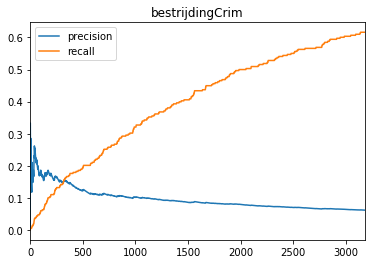

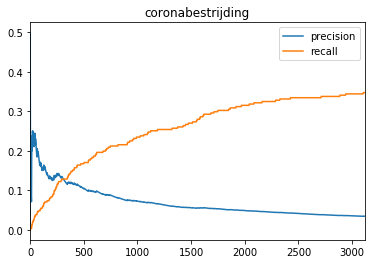

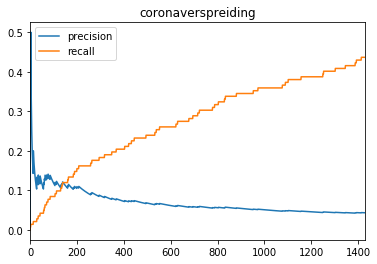

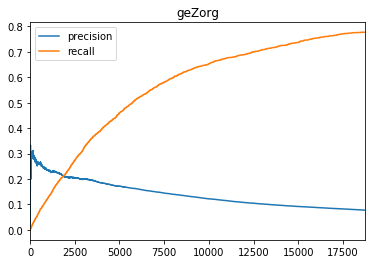

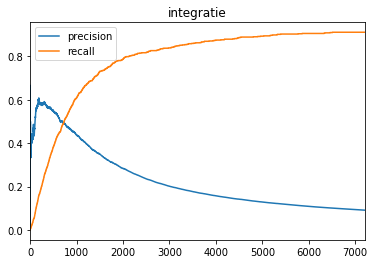

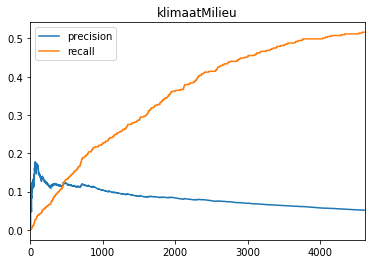

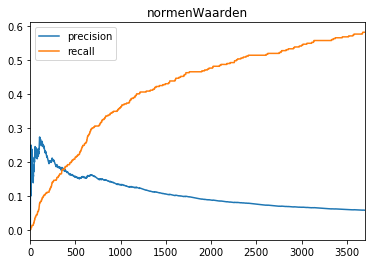

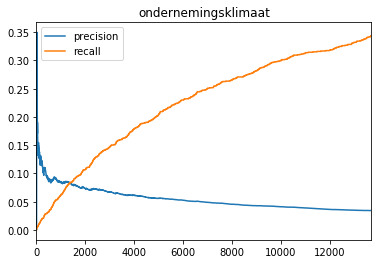

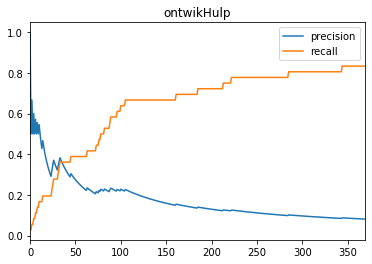

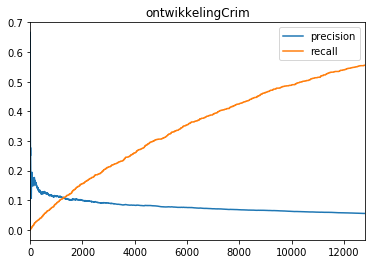

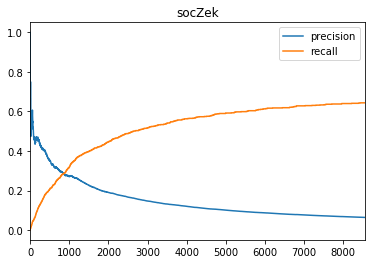

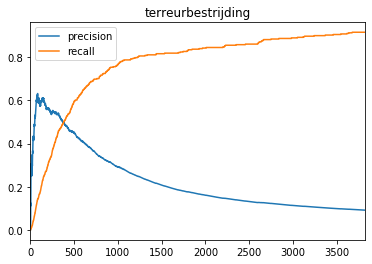

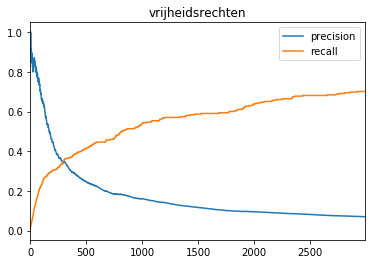

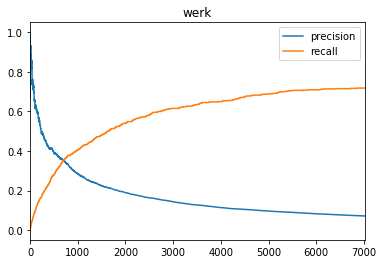

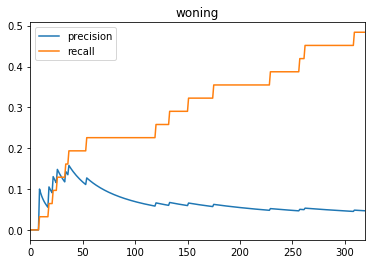

In [23]:
# MAke plots for one individual split
for issue in issue_list:
    # Split randomly in half: one pat for seeds, one part for testing
    seed_words, test_words = split_query_words(issues_dict_expanded[issue])
    # Retrieve most similar words, 10 times the number of test words
    nearest_neighbors = model.wv.most_similar(seed_words, topn=len(test_words)*10)
    # calculate precision and recall
    prec_rec_df = get_prec_recs(nearest_neighbors, test_words)
    # Plot the results
    plot = prec_rec_df.plot()
    plot.set_title(issue)

Now we do the same thing but with cross validation, so we make 10 different splits between seed and test words. We plot the average precision and recall

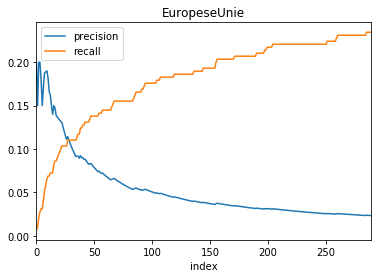

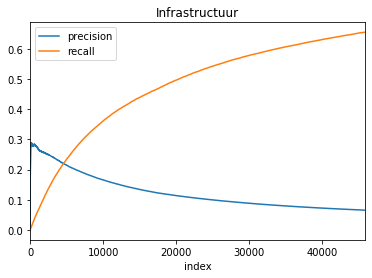

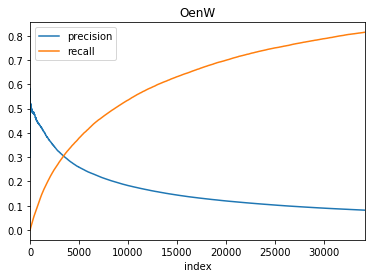

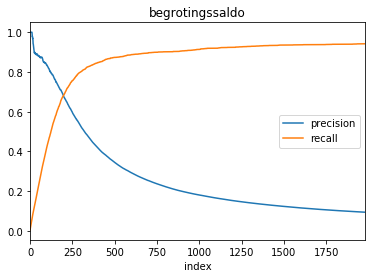

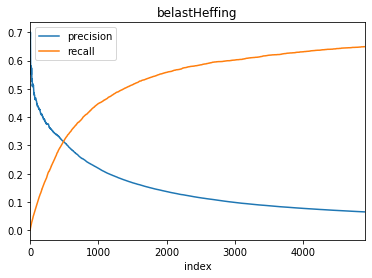

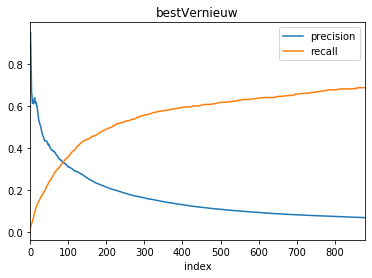

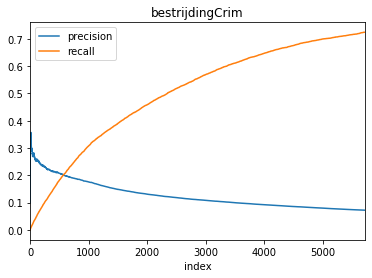

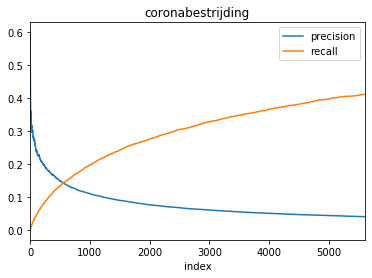

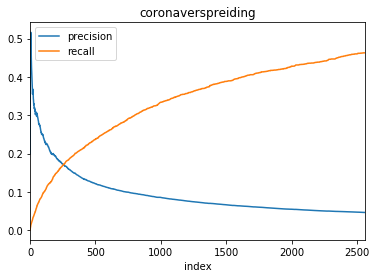

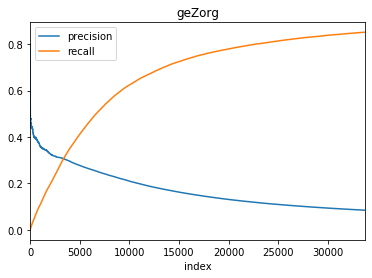

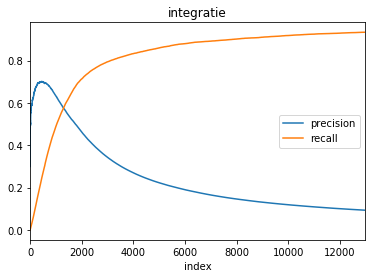

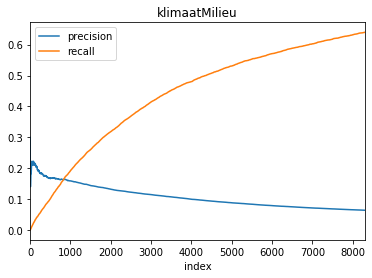

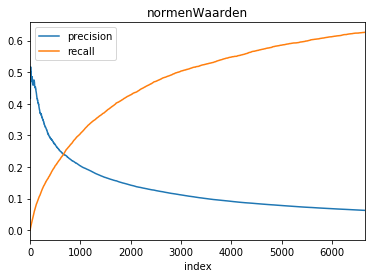

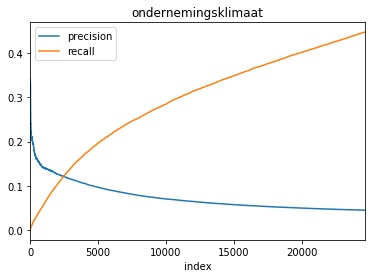

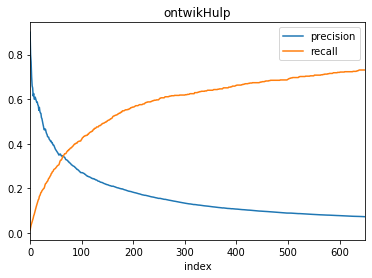

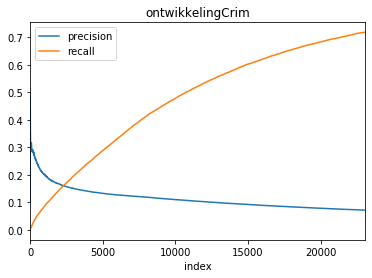

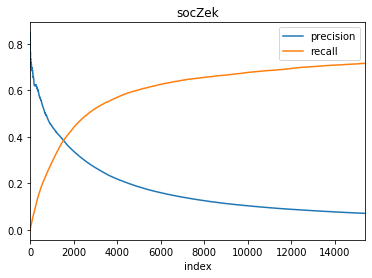

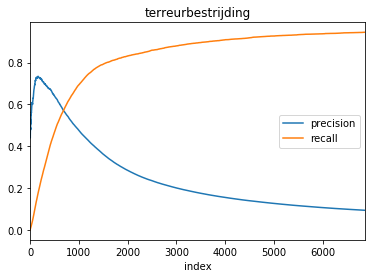

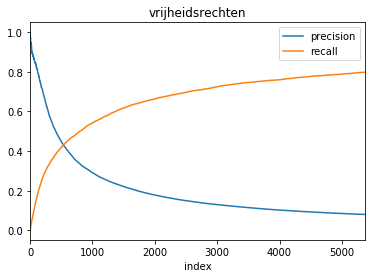

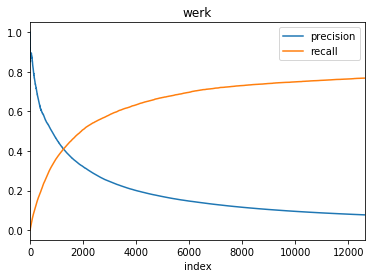

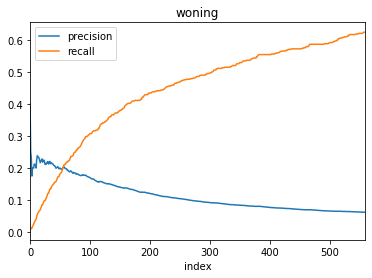

In [40]:
cv_iterations = 10
split_ratio = 0.1 # What fraction of the query terms do we take as seed

for issue in issue_list:
    df_list = []
    for i in range(cv_iterations):
        # Split randomly in half: one pat for seeds, one part for testing
        seed_words, test_words = split_query_words(issues_dict_expanded[issue], split_ratio=split_ratio)
        nearest_neighbors = model.wv.most_similar(seed_words, topn=len(test_words)*10)
        prec_rec_df = get_prec_recs(nearest_neighbors, test_words)
        prec_rec_df = prec_rec_df.reset_index()
        prec_rec_df['cv'] = i
        df_list.append(prec_rec_df)
    prec_rec_df = pd.concat(df_list)
    prec_rec_df_means = prec_rec_df.groupby('index')[['precision', 'recall']].mean()
    plot = prec_rec_df_means.plot()
    plot.set_title(issue)
    plt.show()